In [27]:
from astropy.io import fits
from astropy.table import Table
import numpy as np
import matplotlib.pyplot as plt
from corner import hist2d
from scipy.io.idl import readsav
import src
import matplotlib.cm as cm
from matplotlib.colors import Normalize
%matplotlib notebook


# Literature Search

In [2]:
literature_search = Table.read('Catalogs/literature_search_gaia.fits')

In [3]:
g_ls = literature_search['phot_g_mean_mag']
rp_ls = literature_search['phot_rp_mean_mag']
g_abs_ls = g_ls - 5*(np.log10(1e3/literature_search['parallax'])-1)

/Users/rociokiman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


# Moving Groups

In [4]:
#Reference files
mg_ref = Table.read('data/moving_groups_ref.csv')
file_source_ref = Table.read('data/source_ref.csv')
#Data files
mg_confirmed = Table.read('Catalogs/literature_search_mg.fits')
mg_all = fits.open('Catalogs/literature_search.fits')

In [5]:
g = mg_confirmed['g_corr']
rp = mg_confirmed['rp_corr']
g_rp = g-rp
parallax = mg_confirmed['parallax']
g_abs = mg_confirmed['g_corr'] - 5*(np.log10(1e3/parallax)-1)
group_name = mg_confirmed['group_name']
group_num = mg_confirmed['group_num']
ewha = mg_confirmed['ewha']
ewha_all = mg_confirmed['ewha_all']
age = mg_confirmed['age']/1e6
source_id = mg_confirmed['gaia_source_id']

In [8]:
def find_idx_singles(catalog):
    same_star = catalog['star_index']
    seen = []
    idx = []
    for i,x in enumerate(same_star):
        if(x=='nan'):
            idx.append(i)
        else:
            if(x not in seen):
                seen.append(x)
                idx.append(i)
    return np.array(idx)

In [9]:
idx_singles = find_idx_singles(mg_confirmed[~np.isnan(mg_confirmed['ewha'])])
mask_compatible = np.array([x in idx_singles for x in np.arange(len(mg_confirmed))])

In [10]:
bins_name = np.array(mg_ref['name'])
bins_num = np.array(mg_ref['group_num'])
confirmed_name = mg_confirmed['group_name']
confirmed_num = mg_confirmed['group_num']
confirmed_age = mg_confirmed['age']/1e6

In [11]:
target_url = 'https://zenodo.org/record/2636692/files/MLSDSS-GaiaDR2_extended.fits?download=1'
mlsdss = fits.open(target_url)

subred = mlsdss[1].data['photometric_sample_subred'] == 1

ewha_ml = mlsdss[1].data['EWHA'][subred]
color_ml = mlsdss[1].data['phot_g_mean_mag'][subred]-mlsdss[1].data['phot_rp_mean_mag'][subred]
abs_mag_ml = mlsdss[1].data['phot_g_mean_mag'][subred] - 5*np.log10(1e3/mlsdss[1].data['parallax'][subred]-1)

r_ext = mlsdss[1].data['EXTINCTION'][:,2]
z_ext = mlsdss[1].data['EXTINCTION'][:,4]
ext = r_ext-z_ext
subred = mlsdss[1].data['photometric_sample_subred'] == 1
mask_ext = ext < 0.1

G_ml = mlsdss[1].data['phot_g_mean_mag'][subred*mask_ext]
RP_ml = mlsdss[1].data['phot_rp_mean_mag'][subred*mask_ext]
G_RP_ml = G_ml-RP_ml
parallax_ml = mlsdss[1].data['parallax'][subred*mask_ext]
dist_ml = 1e3/parallax_ml
G_abs_ml = G_ml + 5.0 - 5.0*np.log10(dist_ml)

In [12]:
mlsdss[1].data['MAG_2MASS'][:,2]

array([14.89 , 15.15 , 14.375, ..., 14.733, 13.097, 15.585], dtype=float32)

In [13]:
n_tot = len(mg_confirmed['group_num'])
n_compatible = len(mg_confirmed[mask_compatible])

In [14]:
n_tot,n_compatible

(1424, 1052)

In [15]:
idx = np.argsort(np.array(mg_ref['age'][1:]))
labels = np.array(mg_ref['name'][1:])[idx]
x_labels = []
y_compatible1 = []
for x in labels:
    mask = mg_confirmed['group_name'] == x
    n = src.calc_number_single_stars(mg_confirmed[mask*(~np.isnan(mg_confirmed['ewha']))])
    if(n!=0):
        x_labels.append(x)
        y_compatible1.append(n)
x_axis = np.arange(len(y_compatible1))

In [16]:
for x,y in zip(x_labels,y_compatible1):
    print(x,y)

TAU 4
EPSC 9
USCO 186
UCRA 1
TWA 12
ETAC 1
LCC 25
UCL 8
BPMG 79
OCT 1
COL 23
THA 114
CAR 11
PLE 112
ABDMG 79
CARN 10
UMA 2
CBER 10
PRA 266
HYA 99


<IPython.core.display.Javascript object>


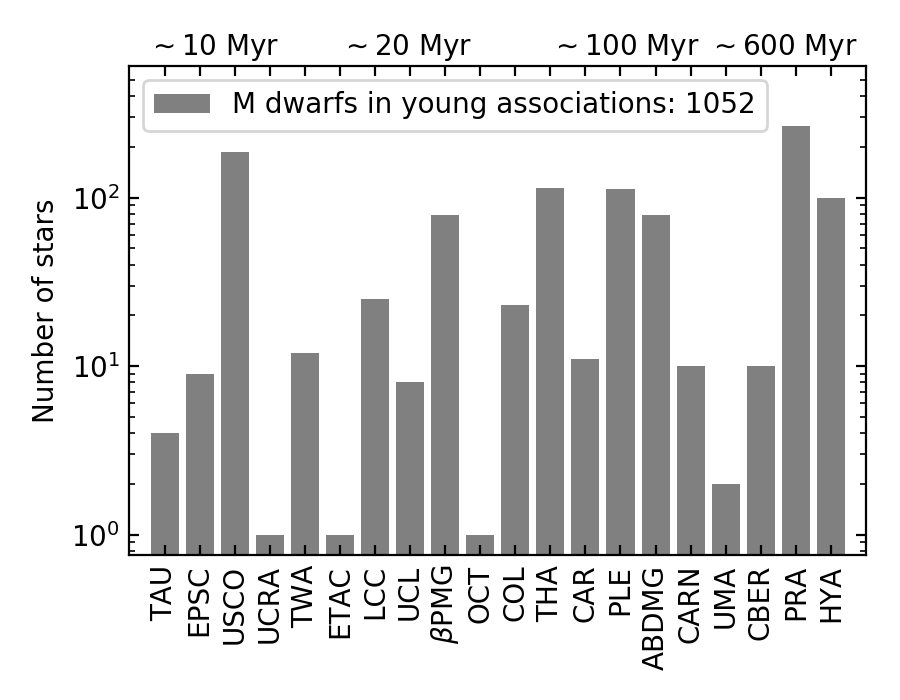

In [20]:
fs=10
plt.figure(figsize=(4.5,3.5))
#plt.bar(bins[:-1],y1,label='Total: {}'.format(n_tot),
#        color='#1c9099')

plt.bar(x_axis,y_compatible1,
        label='M dwarfs in young associations: {}'.format(sum(y_compatible1)),
        color='grey')
plt.xticks(x_axis, ['TAU', 'EPSC', 'USCO', 'UCRA', 'TWA', 'ETAC', 'LCC', 'UCL', r'$\beta$PMG',
       'OCT', 'COL', 'THA', 'CAR', 'PLE', 'ABDMG', 'CARN', 'UMA', 'CBER',
       'PRA', 'HYA'], rotation=90)#copy the list above
plt.yscale('log')
plt.xlim(-1,20)
plt.ylim(0,600)
plt.tick_params('both',direction='in',top=True,right=True)
plt.tick_params('y',which='minor',direction='in',right=True)
plt.text(-0.5,700,'$\sim 10$ Myr',fontsize=fs)
plt.text(5,700,'$\sim 20$ Myr',fontsize=fs)
plt.text(11,700,'$\sim 100$ Myr',fontsize=fs)
plt.text(15.5,700,'$\sim 600$ Myr',fontsize=fs)
plt.ylabel('Number of stars')
plt.legend(loc=2)
plt.tight_layout()
plt.savefig('/Users/rociokiman/Dropbox (Personal)/Apps/Overleaf/Age-Activity Relation for M dwarfs/Mdwarfpergroup.png',
            dpi=300,tight_layout=True)
plt.show()

In [23]:
for x,y in zip(labels[mask_not_zero],y_compatible1[mask_not_zero]):
    print(x,y)

TAU 8
EPSC 10
USCO 174
UCRA 1
TWA 16
ETAC 2
LCC 15
UCL 3
BPMG 77
OCT 1
COL 23
THA 111
CAR 9
PLE 112
ABDMG 95
CARN 13
UMA 4
CBER 10
PRA 269
HYA 99


<IPython.core.display.Javascript object>


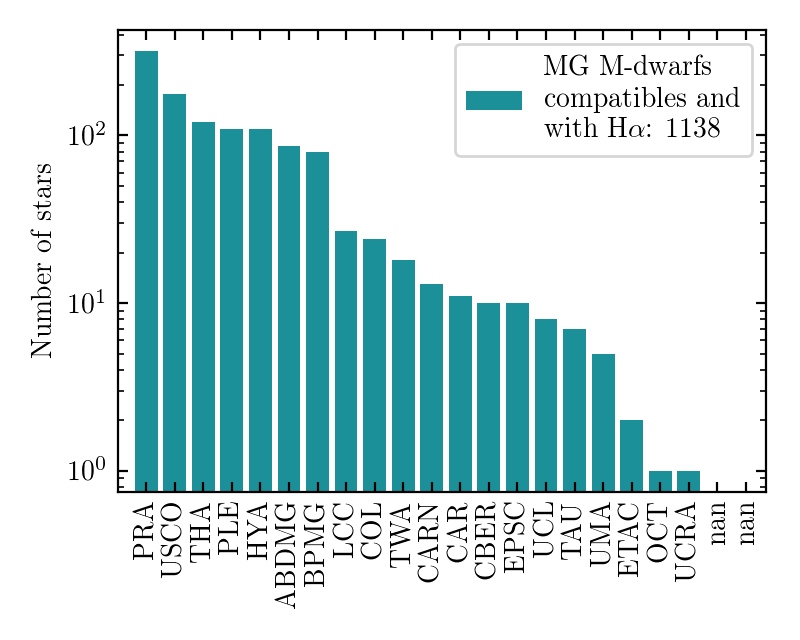

[319 176 120 110 109  87  80  27  24  18  13  11  10  10   8   7   5   2
   1   1   0   0   0   0   0   0   0   0   0   0   0]


In [28]:
#Plot histogram of Moving groups
labels = bins_name
x2 = bins_num

N = len(bins_name) 
bins = np.arange(1,N+1)
#y,bin_edges = np.histogram(mg_confirmed[1].data['group_num'],bins=bins)
#idx = np.flip(np.argsort(y))
#y1,x1 = y[idx],bin_edges[idx]
y_compatible,bin_edges_compatible = np.histogram(confirmed_num[mask_compatible],
                                                 bins=bins)
idx = np.flip(np.argsort(y_compatible))
y_compatible1,x1 = y_compatible[idx],bin_edges_compatible[idx]
labels = np.array([confirmed_name[confirmed_num == x1_i][0] 
                   if len(confirmed_name[confirmed_num == x1_i])!=0 
                   else np.nan for x1_i in x1])

n_tot = len(mg_confirmed['group_num'])
n_compatible = len(mg_confirmed['group_num'][mask_compatible])

plt.figure(figsize=(4,3.2))
#plt.bar(bins[:-1],y1,label='Total: {}'.format(n_tot),
#        color='#1c9099')
plt.bar(bins[:-1],y_compatible1,
        label='MG M-dwarfs\ncompatibles and\n'+r'with H$\alpha$: {}'.format(n_compatible),
        color='#1c9099')
plt.xticks(bins[:-1], labels, rotation=90)
plt.yscale('log')
plt.xlim(0,22.7)
plt.tick_params('both',direction='in',top=True,right=True)
plt.tick_params('y',which='minor',direction='in',right=True)
plt.ylabel('Number of stars')
plt.legend()
plt.tight_layout()
#plt.savefig('/Users/rociokiman/Dropbox (Personal)/Apps/Overleaf/Age-Activity Relation for M dwarfs/Mdwarfpergroup.png',
#            dpi=300,tight_layout=True)
plt.show()

print(y_compatible1)


In [21]:
PLE_model = readsav('Catalogs/Models/dr2_seq_fit_cf_PLE.sav')
BPMG_THOR_model = readsav('Catalogs/Models/dr2_seq_fit_cf_BPMG_THOR.sav')
HYA_model = readsav('Catalogs/Models/dr2_seq_fit_cf_HYA.sav')
CBER_model = readsav('Catalogs/Models/dr2_seq_fit_cf_CBER.sav')
TWA_model = readsav('Catalogs/Models/dr2_seq_fit_cf_TWA.sav')
THA_model = readsav('Catalogs/Models/dr2_seq_fit_cf_THA_COL_CAR.sav')
USCO_model = readsav('Catalogs/Models/dr2_seq_fit_cf_USCO_LCC_UCL.sav')

In [22]:
color_pra = g_rp[group_name=='PRA']
abs_mag_pra = g_abs[group_name=='PRA']
p_pra = np.polyfit(color_pra,abs_mag_pra,8)
mask_outliers = abs((np.polyval(p_pra,color_pra)- abs_mag_pra)) < 0.15
for i in range(30):
    p_pra = np.polyfit(color_pra[mask_outliers],abs_mag_pra[mask_outliers],8)
    mask_outliers = abs((np.polyval(p_pra,color_pra)- abs_mag_pra)) < 0.15

In [23]:
N = 30
x_ple = np.linspace(PLE_model['color_range'][0],PLE_model['color_range'][1],N)
y_ple = np.polyval(np.flipud(PLE_model['cf']),x_ple)

x_bpmg_thor = np.linspace(BPMG_THOR_model['color_range'][0],BPMG_THOR_model['color_range'][1],N)
y_bpmg_thor = np.polyval(np.flipud(BPMG_THOR_model['cf']),x_bpmg_thor)

x_hya = np.linspace(HYA_model['color_range'][0],HYA_model['color_range'][1],N)
y_hya = np.polyval(np.flipud(HYA_model['cf']),x_hya)

x_cber = np.linspace(CBER_model['color_range'][0],CBER_model['color_range'][1],N)
y_cber = np.polyval(np.flipud(CBER_model['cf']),x_cber)

x_twa = np.linspace(TWA_model['color_range'][0],TWA_model['color_range'][1],N)
y_twa = np.polyval(np.flipud(TWA_model['cf']),x_twa)

x_tha = np.linspace(THA_model['color_range'][0],THA_model['color_range'][1],N)
y_tha = np.polyval(np.flipud(THA_model['cf']),x_tha)

x_usco = np.linspace(USCO_model['color_range'][0],USCO_model['color_range'][1],N)
y_usco = np.polyval(np.flipud(USCO_model['cf']),x_usco)

x_pra = np.linspace(np.nanmin(color_pra),1.4,N)
y_pra = np.polyval(p_pra,x_pra)

In [30]:
new_mem = Table.read('data/new_members_data.csv',format='csv',delimiter='\t')
source_id_new_mem = new_mem['source_id']
mask_new_mem = np.array([x in source_id_new_mem for x in source_id])


In [17]:
bfmembers = Table.read('Catalogs/bfmembers.fits')

In [18]:
bfmembers.columns

<TableColumns names=('group','ra','dec','g','rp','parallax','g_abs','j','k','Li','Li_err','fuv','haew','haew_err')>

In [20]:
N = 30
group = 'PLE'
x_ple = bfmembers['g'][bfmembers['group']==group]-bfmembers['rp'][bfmembers['group']==group]
y_ple = bfmembers['g'][bfmembers['group']==group]-5*(np.log10(1e3/bfmembers['parallax'][bfmembers['group']==group])-1)

group='BPMG'
x_bpmg_thor = bfmembers['g'][bfmembers['group']==group]-bfmembers['rp'][bfmembers['group']==group]
y_bpmg_thor = bfmembers['g'][bfmembers['group']==group]-5*(np.log10(1e3/bfmembers['parallax'][bfmembers['group']==group])-1)

group='HYA'
x_hya = bfmembers['g'][bfmembers['group']==group]-bfmembers['rp'][bfmembers['group']==group]
y_hya = bfmembers['g'][bfmembers['group']==group]-5*(np.log10(1e3/bfmembers['parallax'][bfmembers['group']==group])-1)

group='CBER'
x_cber = bfmembers['g'][bfmembers['group']==group]-bfmembers['rp'][bfmembers['group']==group]
y_cber = bfmembers['g'][bfmembers['group']==group]-5*(np.log10(1e3/bfmembers['parallax'][bfmembers['group']==group])-1)

group='TWA'
x_twa = bfmembers['g'][bfmembers['group']==group]-bfmembers['rp'][bfmembers['group']==group]
y_twa = bfmembers['g'][bfmembers['group']==group]-5*(np.log10(1e3/bfmembers['parallax'][bfmembers['group']==group])-1)

group='THA'
x_tha = bfmembers['g'][bfmembers['group']==group]-bfmembers['rp'][bfmembers['group']==group]
y_tha = bfmembers['g'][bfmembers['group']==group]-5*(np.log10(1e3/bfmembers['parallax'][bfmembers['group']==group])-1)

group='USCO'
x_usco = bfmembers['g'][bfmembers['group']==group]-bfmembers['rp'][bfmembers['group']==group]
y_usco = bfmembers['g'][bfmembers['group']==group]-5*(np.log10(1e3/bfmembers['parallax'][bfmembers['group']==group])-1)

#x_pra = np.linspace(np.nanmin(color_pra),1.4,N)
#y_pra = np.polyval(p_pra,x_pra)

/Users/rociokiman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in log10


<IPython.core.display.Javascript object>


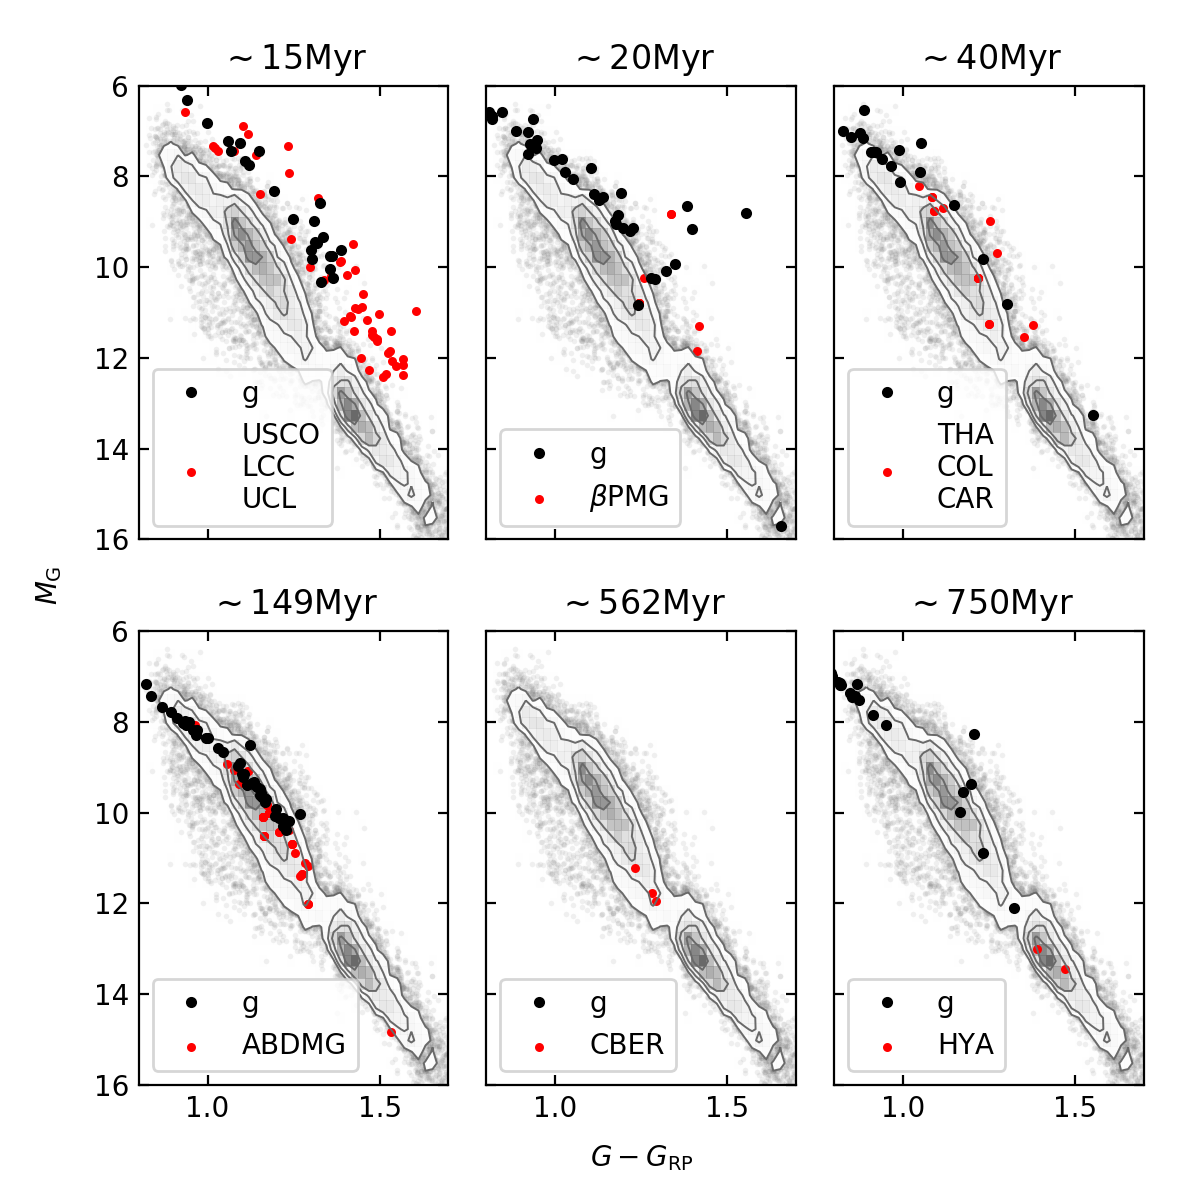

In [32]:
contour_color = 'dimgray'
s = 5
color = 'r'#'#ef8a62'
color_fit = 'k'
lw =1
loc=3

fig, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3,sharex=True,sharey=True,figsize=(6,6))

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

'''
hist2d(G_RP_ml, G_abs_ml,
       bins=50,plot_contours=True,plot_datapoints=True, color=contour_color,
       contour_kwargs={"linewidths":0.7},ax=ax1)
mask_twa = (group_name=='TWA')*mask_new_mem
ax1.scatter(g_rp[mask_twa],g_abs[mask_twa],s=s,label='TWA',
            color=color)
ax1.plot(x_twa,y_twa,'.',color=color_fit,linewidth=lw)
ax1.tick_params('both',direction='in',top=True,right=True)
ax1.tick_params('y',which='minor',direction='in',right=True)
ax1.set_title(r'$\sim 10$Myr')
ax1.legend(loc=loc)
'''
hist2d(G_RP_ml, G_abs_ml,
       bins=50,plot_contours=True,plot_datapoints=True, color=contour_color,
       contour_kwargs={"linewidths":0.7},ax=ax1)
mask_usco = np.logical_or(group_name=='USCO',group_name=='LCC',group_name=='UCL') * mask_new_mem
ax1.scatter(g_rp[mask_usco],g_abs[mask_usco],s=s,label='USCO\nLCC\nUCL',
            color=color)
ax1.plot(x_usco,y_usco,'.',color=color_fit)
ax1.tick_params('both',direction='in',top=True,right=True)
ax1.tick_params('y',which='minor',direction='in',right=True)
ax1.set_title(r'$\sim 15$Myr')
ax1.legend(loc=loc)


hist2d(G_RP_ml, G_abs_ml,
       bins=50,plot_contours=True,plot_datapoints=True, color=contour_color,
       contour_kwargs={"linewidths":0.7},ax=ax2)
mask_bpmg = np.logical_or(group_name=='BPMG',group_name=='THOR') * mask_new_mem
ax2.scatter(g_rp[mask_bpmg],g_abs[mask_bpmg],s=s,label=r'$\beta$PMG',#+'\nTHOR',
            color=color)
ax2.plot(x_bpmg_thor,y_bpmg_thor,'.',color=color_fit)
ax2.tick_params('both',direction='in',top=True,right=True)
ax2.tick_params('y',which='minor',direction='in',right=True)
ax2.set_title(r'$\sim 20$Myr')
ax2.legend(loc=loc)

hist2d(G_RP_ml, G_abs_ml,
       bins=50,plot_contours=True,plot_datapoints=True, color=contour_color,
       contour_kwargs={"linewidths":0.7},ax=ax3)
mask_tha = np.logical_or(group_name=='THA',group_name=='COL',group_name=='CAR') * mask_new_mem
ax3.scatter(g_rp[mask_tha],g_abs[mask_tha],s=s,label='THA\nCOL\nCAR',
            color=color)
ax3.plot(x_tha,y_tha,'.',color=color_fit)
ax3.tick_params('both',direction='in',top=True,right=True)
ax3.tick_params('y',which='minor',direction='in',right=True)
ax3.set_title(r'$\sim 40$Myr')
ax3.legend(loc=loc)
'''
hist2d(G_RP_ml, G_abs_ml,
       bins=50,plot_contours=True,plot_datapoints=True, color=contour_color,
       contour_kwargs={"linewidths":0.7},ax=ax5)
mask_ple = (group_name=='PLE') * mask_new_mem
ax5.scatter(g_rp[mask_ple],g_abs[mask_ple],s=s,label='PLE',
            color=color)
ax5.plot(x_ple,y_ple,'.',color=color_fit,linewidth=lw)
ax5.tick_params('both',direction='in',top=True,right=True)
ax5.tick_params('y',which='minor',direction='in',right=True)
ax5.set_title(r'$\sim 112$Myr')
ax5.legend(loc=loc)
'''

hist2d(G_RP_ml, G_abs_ml,
       bins=50,plot_contours=True,plot_datapoints=True, color=contour_color,
       contour_kwargs={"linewidths":0.7},ax=ax4)
mask_abdmg = (group_name=='ABDMG') * mask_new_mem
ax4.scatter(g_rp[mask_abdmg],g_abs[mask_abdmg],s=s,label='ABDMG',
            color=color) #almost no PLE mem and ages are similar
ax4.plot(x_ple,y_ple,'.',color=color_fit)
ax4.tick_params('both',direction='in',top=True,right=True)
ax4.tick_params('y',which='minor',direction='in',right=True)
ax4.set_title(r'$\sim 149$Myr')
ax4.legend(loc=loc)

hist2d(G_RP_ml, G_abs_ml,
       bins=50,plot_contours=True,plot_datapoints=True, color=contour_color,
       contour_kwargs={"linewidths":0.7},ax=ax5)
mask_cber = (group_name=='CBER') * mask_new_mem
ax5.scatter(g_rp[mask_cber],g_abs[mask_cber],s=s,label='CBER',
            color=color)
ax5.plot(x_cber,y_cber,'.',color=color_fit)
ax5.tick_params('both',direction='in',top=True,right=True)
ax5.tick_params('y',which='minor',direction='in',right=True)
ax5.set_title(r'$\sim 562$Myr')
ax5.legend(loc=loc)
'''
hist2d(G_RP_ml, G_abs_ml,
       bins=50,plot_contours=True,plot_datapoints=True, color=contour_color,
       contour_kwargs={"linewidths":0.7},ax=ax7)
mask_pra = (group_name=='PRA') * mask_new_mem
ax7.scatter(g_rp[mask_pra],g_abs[mask_pra],s=s,label='PRA',
            color=color)
ax7.plot(x_pra,y_pra,'.',color=color_fit,linewidth=lw)
ax7.tick_params('both',direction='in',top=True,right=True)
ax7.tick_params('y',which='minor',direction='in',right=True)
ax7.set_title(r'$\sim 650$Myr')
ax7.legend(loc=loc)
'''
hist2d(G_RP_ml, G_abs_ml,
       bins=50,plot_contours=True,plot_datapoints=True, color=contour_color,
       contour_kwargs={"linewidths":0.7},ax=ax6)
mask_hya = (group_name=='HYA') * mask_new_mem
ax6.scatter(g_rp[mask_hya],g_abs[mask_hya],s=s,label='HYA',
            color=color)
ax6.plot(x_hya,y_hya,'.',color=color_fit)
ax6.tick_params('both',direction='in',top=True,right=True)
ax6.tick_params('y',which='minor',direction='in',right=True)
ax6.set_title(r'$\sim 750$Myr')
ax6.legend(loc=loc)
ax6.set_ylim(16,6)
ax6.set_xlim(0.8,1.7)

plt.tight_layout()
plt.xlabel(r'$G-G_{\rm RP}$')
plt.ylabel(r'$M_{\rm G}$')

#plt.savefig('/Users/rociokiman/Dropbox (Personal)/Apps/Overleaf/Age-Activity Relation for M dwarfs/ModelsGroups.png',
#            dpi=300,tight_layout=True)

plt.show()

<IPython.core.display.Javascript object>


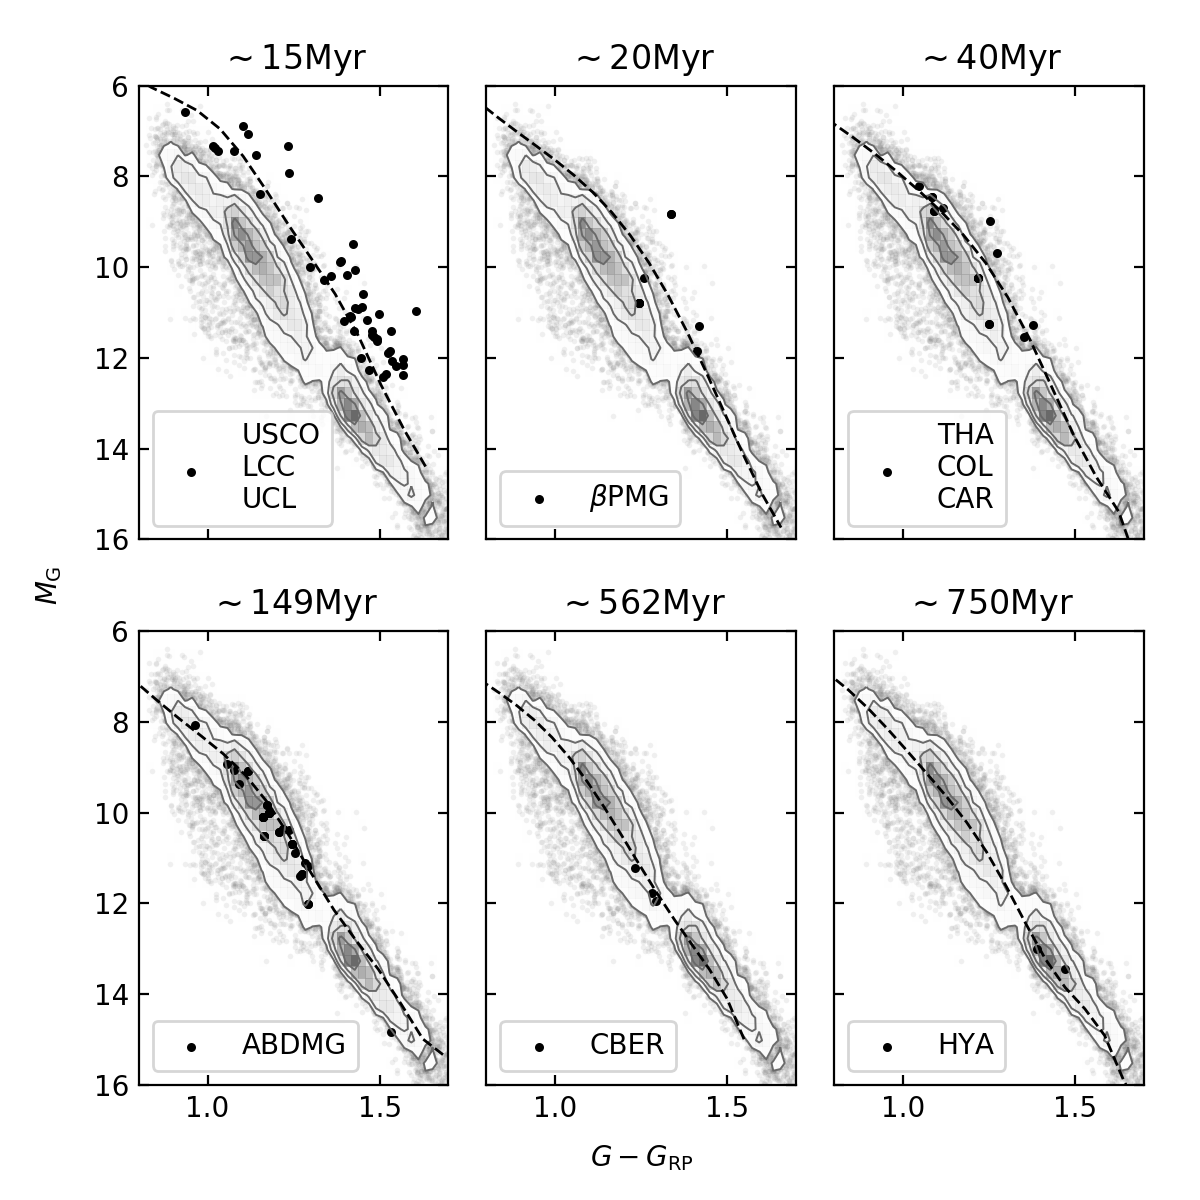

In [26]:
contour_color = 'dimgray'
s = 5
color = 'k'#'#ef8a62'
color_fit = 'k'
lw =1
loc=3

fig, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3,sharex=True,sharey=True,figsize=(6,6))

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

'''
hist2d(G_RP_ml, G_abs_ml,
       bins=50,plot_contours=True,plot_datapoints=True, color=contour_color,
       contour_kwargs={"linewidths":0.7},ax=ax1)
mask_twa = (group_name=='TWA')*mask_new_mem
ax1.scatter(g_rp[mask_twa],g_abs[mask_twa],s=s,label='TWA',
            color=color)
ax1.plot(x_twa,y_twa,'--',color=color_fit,linewidth=lw)
ax1.tick_params('both',direction='in',top=True,right=True)
ax1.tick_params('y',which='minor',direction='in',right=True)
ax1.set_title(r'$\sim 10$Myr')
ax1.legend(loc=loc)
'''
hist2d(G_RP_ml, G_abs_ml,
       bins=50,plot_contours=True,plot_datapoints=True, color=contour_color,
       contour_kwargs={"linewidths":0.7},ax=ax1)
mask_usco = np.logical_or(group_name=='USCO',group_name=='LCC',group_name=='UCL') * mask_new_mem
ax1.scatter(g_rp[mask_usco],g_abs[mask_usco],s=s,label='USCO\nLCC\nUCL',
            color=color)
ax1.plot(x_usco,y_usco,'--',color=color_fit,linewidth=lw)
ax1.tick_params('both',direction='in',top=True,right=True)
ax1.tick_params('y',which='minor',direction='in',right=True)
ax1.set_title(r'$\sim 15$Myr')
ax1.legend(loc=loc)


hist2d(G_RP_ml, G_abs_ml,
       bins=50,plot_contours=True,plot_datapoints=True, color=contour_color,
       contour_kwargs={"linewidths":0.7},ax=ax2)
mask_bpmg = np.logical_or(group_name=='BPMG',group_name=='THOR') * mask_new_mem
ax2.scatter(g_rp[mask_bpmg],g_abs[mask_bpmg],s=s,label=r'$\beta$PMG',#+'\nTHOR',
            color=color)
ax2.plot(x_bpmg_thor,y_bpmg_thor,'--',color=color_fit,linewidth=lw)
ax2.tick_params('both',direction='in',top=True,right=True)
ax2.tick_params('y',which='minor',direction='in',right=True)
ax2.set_title(r'$\sim 20$Myr')
ax2.legend(loc=loc)

hist2d(G_RP_ml, G_abs_ml,
       bins=50,plot_contours=True,plot_datapoints=True, color=contour_color,
       contour_kwargs={"linewidths":0.7},ax=ax3)
mask_tha = np.logical_or(group_name=='THA',group_name=='COL',group_name=='CAR') * mask_new_mem
ax3.scatter(g_rp[mask_tha],g_abs[mask_tha],s=s,label='THA\nCOL\nCAR',
            color=color)
ax3.plot(x_tha,y_tha,'--',color=color_fit,linewidth=lw)
ax3.tick_params('both',direction='in',top=True,right=True)
ax3.tick_params('y',which='minor',direction='in',right=True)
ax3.set_title(r'$\sim 40$Myr')
ax3.legend(loc=loc)
'''
hist2d(G_RP_ml, G_abs_ml,
       bins=50,plot_contours=True,plot_datapoints=True, color=contour_color,
       contour_kwargs={"linewidths":0.7},ax=ax5)
mask_ple = (group_name=='PLE') * mask_new_mem
ax5.scatter(g_rp[mask_ple],g_abs[mask_ple],s=s,label='PLE',
            color=color)
ax5.plot(x_ple,y_ple,'--',color=color_fit,linewidth=lw)
ax5.tick_params('both',direction='in',top=True,right=True)
ax5.tick_params('y',which='minor',direction='in',right=True)
ax5.set_title(r'$\sim 112$Myr')
ax5.legend(loc=loc)
'''

hist2d(G_RP_ml, G_abs_ml,
       bins=50,plot_contours=True,plot_datapoints=True, color=contour_color,
       contour_kwargs={"linewidths":0.7},ax=ax4)
mask_abdmg = (group_name=='ABDMG') * mask_new_mem
ax4.scatter(g_rp[mask_abdmg],g_abs[mask_abdmg],s=s,label='ABDMG',
            color=color) #almost no PLE mem and ages are similar
ax4.plot(x_ple,y_ple,'--',color=color_fit,linewidth=lw)
ax4.tick_params('both',direction='in',top=True,right=True)
ax4.tick_params('y',which='minor',direction='in',right=True)
ax4.set_title(r'$\sim 149$Myr')
ax4.legend(loc=loc)

hist2d(G_RP_ml, G_abs_ml,
       bins=50,plot_contours=True,plot_datapoints=True, color=contour_color,
       contour_kwargs={"linewidths":0.7},ax=ax5)
mask_cber = (group_name=='CBER') * mask_new_mem
ax5.scatter(g_rp[mask_cber],g_abs[mask_cber],s=s,label='CBER',
            color=color)
ax5.plot(x_cber,y_cber,'--',color=color_fit,linewidth=lw)
ax5.tick_params('both',direction='in',top=True,right=True)
ax5.tick_params('y',which='minor',direction='in',right=True)
ax5.set_title(r'$\sim 562$Myr')
ax5.legend(loc=loc)
'''
hist2d(G_RP_ml, G_abs_ml,
       bins=50,plot_contours=True,plot_datapoints=True, color=contour_color,
       contour_kwargs={"linewidths":0.7},ax=ax7)
mask_pra = (group_name=='PRA') * mask_new_mem
ax7.scatter(g_rp[mask_pra],g_abs[mask_pra],s=s,label='PRA',
            color=color)
ax7.plot(x_pra,y_pra,'--',color=color_fit,linewidth=lw)
ax7.tick_params('both',direction='in',top=True,right=True)
ax7.tick_params('y',which='minor',direction='in',right=True)
ax7.set_title(r'$\sim 650$Myr')
ax7.legend(loc=loc)
'''
hist2d(G_RP_ml, G_abs_ml,
       bins=50,plot_contours=True,plot_datapoints=True, color=contour_color,
       contour_kwargs={"linewidths":0.7},ax=ax6)
mask_hya = (group_name=='HYA') * mask_new_mem
ax6.scatter(g_rp[mask_hya],g_abs[mask_hya],s=s,label='HYA',
            color=color)
ax6.plot(x_hya,y_hya,'--',color=color_fit,linewidth=lw)
ax6.tick_params('both',direction='in',top=True,right=True)
ax6.tick_params('y',which='minor',direction='in',right=True)
ax6.set_title(r'$\sim 750$Myr')
ax6.legend(loc=loc)
ax6.set_ylim(16,6)
ax6.set_xlim(0.8,1.7)

plt.tight_layout()
plt.xlabel(r'$G-G_{\rm RP}$')
plt.ylabel(r'$M_{\rm G}$')

plt.savefig('/Users/rociokiman/Dropbox (Personal)/Apps/Overleaf/Age-Activity Relation for M dwarfs/ModelsGroups.png',
            dpi=300,tight_layout=True)

plt.show()

# Active Fraction

<IPython.core.display.Javascript object>


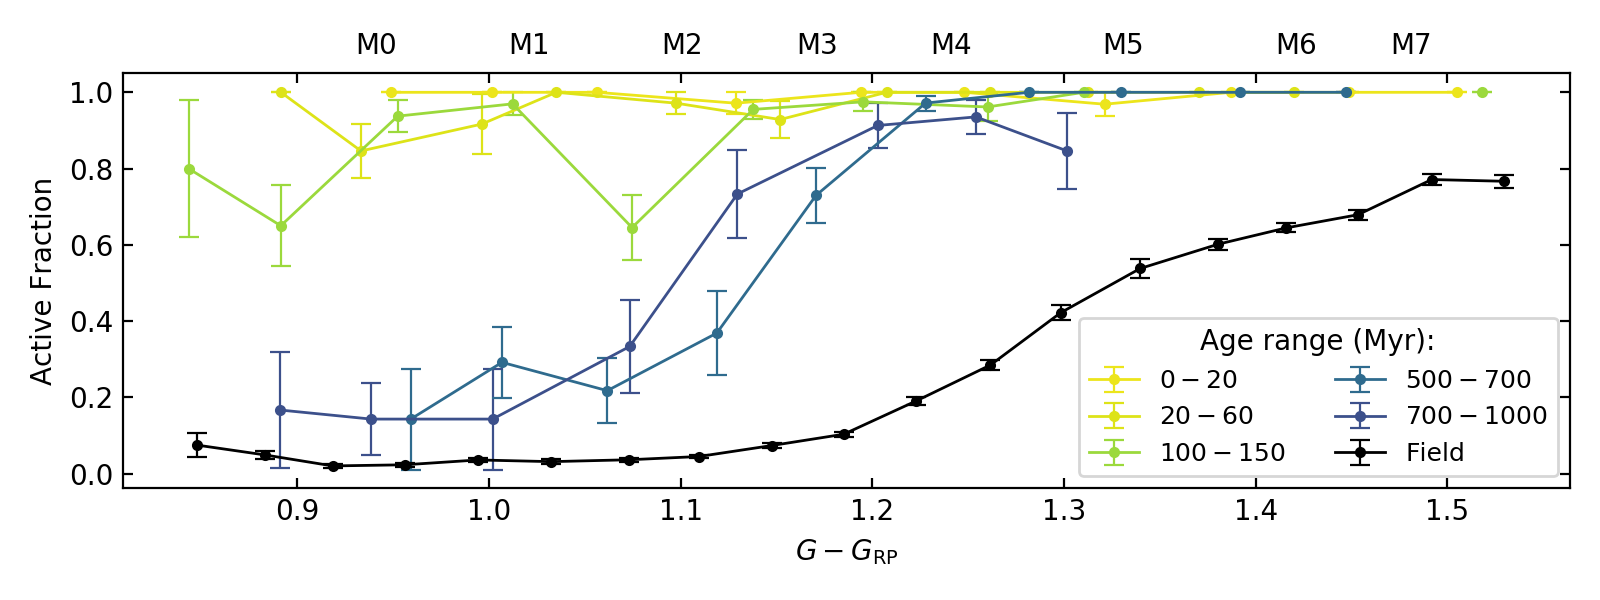

/Users/rociokiman/anaconda3/lib/python3.7/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)
/Users/rociokiman/anaconda3/lib/python3.7/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)
/Users/rociokiman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in less_equal


{'TAU', 'EPSC', 'UCRA', 'ETAC', 'USCO', 'TWA', 'UCL', 'LCC'}
[ 2.  7. 13. 14. 35. 22. 25. 32. 41. 37. 28.]
{'CAR', 'OCT', 'THA', 'BPMG', 'COL'}
[ 6. 26. 12. 22. 35. 28. 65. 76. 45. 29. 14.  3.]
set()
[nan]
set()
[nan]
{'PLE', 'ABDMG'}
[ 5. 20. 32. 33. 31. 67. 40. 26. 10. nan nan  7.]
{'CARN'}
[ 1.  1.  1. nan  9.  3.  1.]
set()
[nan]
{'UMA'}
[nan nan nan nan nan]
{'CBER', 'PRA'}
[ 7. 24. 23. 19. 37. 71. 63. 28. 20. 13.  3.]
{'HYA'}
[ 6. 14.  7. 15. 15. 23. 31. 13.  4. nan]


In [27]:
fractions = open('activity_fraction.csv','a')
fractions.write('#age\tg-rp\tfraction\terror\n')
n_all = []
method1 = 'doane'
n_color = 8
min_color = 0.8
max_color = 1.55
color_range = np.linspace(min_color,max_color,n_color)
age_min = -20
age_max = 1000
age_bins = np.array([0,20,60,80,100,150,200,300,500,700,age_max])#np.linspace(age_min,age_max,10)
cmap = cm.viridis_r
norm = Normalize(vmin=age_min, vmax=age_max)

mask_ml = (~np.isnan(color_ml)) * (color_ml > min_color) * (color_ml < max_color)
color_bin_ml,active_fraction_ml,e_active_fraction_ml,ntot_ml  = src.calc_activity_fraction(color_ml[mask_ml],
                                                                                           ewha_ml[mask_ml],
                                                                                           method1)
y_text = 1.1
n = len(color_bin_ml)
lw = 1
elw = 0.8
f = plt.figure(figsize=(8,3))
cz=3.5

for i in range(len(age_bins)-1):
    mask_age1 = ((age > age_bins[i]) * (age <= age_bins[i+1]) * (~np.isnan(g_rp)) * (~np.isnan(ewha)) 
                 * (g_rp > min_color) * (g_rp < max_color))
    set_group_name = set(group_name[mask_age1])
    print(set_group_name)

    color_bin1,active_fraction1,e_active_fraction1,ntot1  = src.calc_activity_fraction(g_rp[mask_age1],
                                                                                       ewha[mask_age1],
                                                                                       method1)
    mask_ntot = ntot1 <= 4
    active_fraction1[mask_ntot] = np.nan
    
    print(ntot1)
    if(len(active_fraction1[~np.isnan(active_fraction1)])>n_color-4):
        for x in ntot1:
            n_all.append(x)
        plt.errorbar(color_bin1,active_fraction1,
                     yerr=e_active_fraction1,
                     label='${0:.0f} - {1:.0f}$'.format(age_bins[i],age_bins[i+1]),
                     color=cmap(norm(np.nanmean(age[mask_age1]))),
                     linewidth=lw,fmt='.-',elinewidth=elw,capsize=cz,capthick=elw)
        for x,y,z in zip(color_bin1,active_fraction1,e_active_fraction1):
            fractions.write(str(age_bins[i])+'-'+str(age_bins[i+1])+'\t'+str(x)+'\t'+str(y)+'\t'+str(z)+'\n')
plt.errorbar(color_bin_ml,active_fraction_ml,
             yerr=e_active_fraction_ml,
             fmt='.-',label='Field',color='k',
             linewidth=lw,elinewidth=elw,capsize=cz,capthick=elw)
for x,y,z in zip(color_bin_ml,active_fraction_ml,e_active_fraction_ml):
    fractions.write('field\t'+str(x)+'\t'+str(y)+'\t'+str(z)+'\n')
plt.text(0.93,y_text,'M0')
plt.text(1.01,y_text,'M1')
plt.text(1.09,y_text,'M2')
plt.text(1.16,y_text,'M3')
plt.text(1.23,y_text,'M4')
plt.text(1.32,y_text,'M5')
plt.text(1.41,y_text,'M6')
plt.text(1.47,y_text,'M7')
plt.legend(title='Age range (Myr):',loc=4,fontsize=9,ncol=2)#loc='center left', bbox_to_anchor=(1, 0.5), title='Age range:')
plt.tick_params('both',direction='in',top=True,right=True)
plt.tick_params('both',which='minor',direction='in',right=True)
plt.xlabel(r'$G-G_{\rm RP}$')
plt.ylabel('Active Fraction')
plt.tight_layout()
plt.savefig('/Users/rociokiman/Dropbox (Personal)/Apps/Overleaf/Age-Activity Relation for M dwarfs/activefraction.pdf'
            ,tight_layout=True)
fractions.close()